In [1]:
import cv2
import numpy as np
import os.path as op
import matplotlib.pyplot as plt

In [2]:
data_path = op.join('.', 'images', 'long_expo2')
img_type = '.JPG'
img_set = []
exposure_time = []

In [3]:
def imshow(img, cmap=None):
    plt.imshow(img, cmap)
    plt.show()

./images/long_expo2/IMG_0872.JPG
0.0004


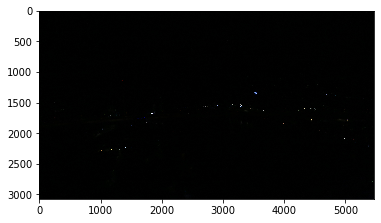

./images/long_expo2/IMG_0873.JPG
0.001


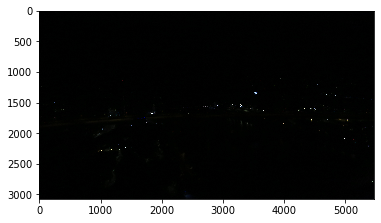

./images/long_expo2/IMG_0874.JPG
0.002


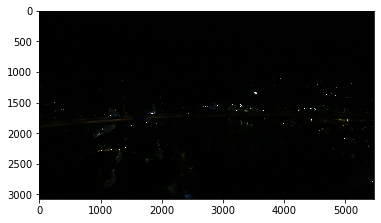

./images/long_expo2/IMG_0875.JPG
0.004


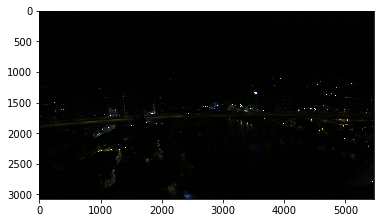

./images/long_expo2/IMG_0876.JPG
0.008


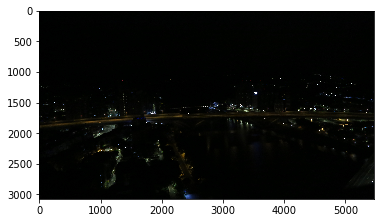

./images/long_expo2/IMG_0877.JPG
0.016666666666666666


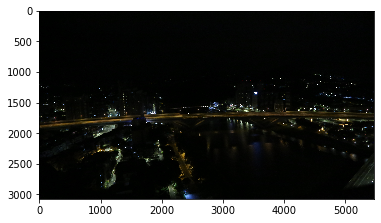

./images/long_expo2/IMG_0878.JPG
0.03333333333333333


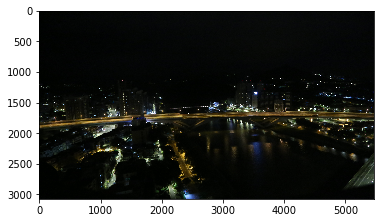

./images/long_expo2/IMG_0879.JPG
0.04


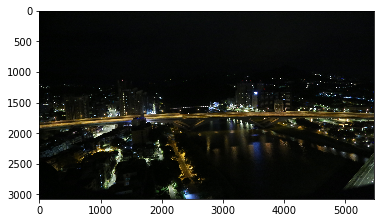

./images/long_expo2/IMG_0880.JPG
0.05


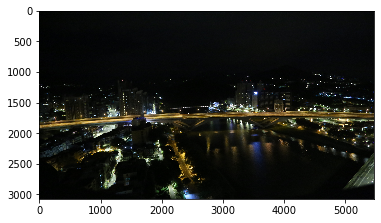

./images/long_expo2/IMG_0881.JPG
0.07692307692307693


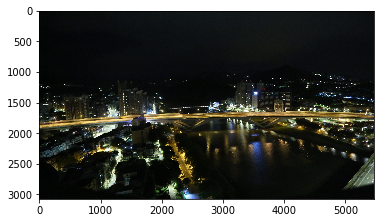

./images/long_expo2/IMG_0882.JPG
0.16666666666666666


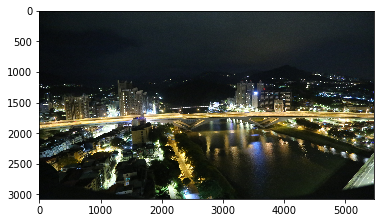

./images/long_expo2/IMG_0883.JPG
0.30000000000000004


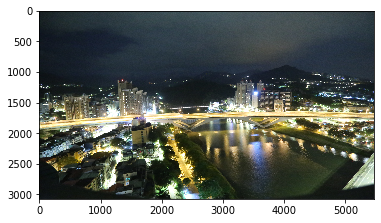

./images/long_expo2/IMG_0884.JPG
0.6000000000000001


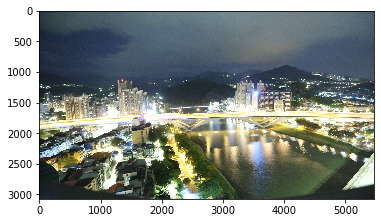

./images/long_expo2/IMG_0885.JPG
1.3


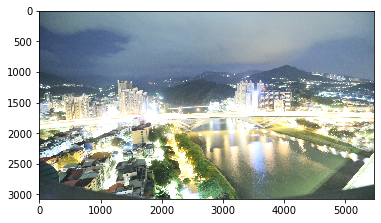

3072 5472 3


In [4]:
img_set = []
exposure_time.clear()

with open(op.join(data_path, 'shutter_speed.csv'), 'r') as fp:
    lines = fp.readlines()

    for line in lines:
        filename, shutter_speed = line.split(', ')
        

        # exposure time
        shutter_speed = shutter_speed.split('\"')
        if len(shutter_speed) == 2:
            exp_t = int(shutter_speed[0]) + 0.1*int(shutter_speed[1])
        else:
            exp_t = 1/int(shutter_speed[0])
        exposure_time.append(exp_t)

        # read image
        filepath = op.join(data_path, filename + img_type)
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_set.append(img)

        # display data
        print(filepath)
        print(exp_t)
        imshow(img)
        
img_set = np.array(img_set)

# parameters
num_imgs = len(img_set)
height, width, channels = img_set[0].shape
print(height, width, channels)


## Sample Pixel
Select pixels for recovering response curve.

In [5]:
num_pixels = 50
# sampled pixels
# should be in shape channels x num_pixels x num_imgs
sampled_pixels = np.array([])

# check if the number of pixels is enough to recover the response curve 
if num_pixels * (num_imgs-1) < 256:
    print('The number of pixels is not enough!')

In [6]:
# Random Sample
x_coords = np.random.randint(0, height, (num_pixels, 1))
y_coords = np.random.randint(0, width, (num_pixels, 1))
coords = np.concatenate((x_coords, y_coords), axis=1)
print(coords)

sampled_pixels = [[[img_set[j][coords[i, 0], coords[i, 1]][c] for j in range(num_imgs)] for i in range(num_pixels)] for c in range(channels)]
sampled_pixels = np.array(sampled_pixels)

print(np.shape(sampled_pixels))

[[ 447 4751]
 [ 462 1561]
 [ 529 2396]
 [1769 4908]
 [ 790 4787]
 [1292 3965]
 [2510 3013]
 [2609 2292]
 [2394 3434]
 [2218 1003]
 [ 149 3152]
 [ 306 4463]
 [1355 2987]
 [ 652  603]
 [1311 1150]
 [ 653  785]
 [ 454 3819]
 [1401 1729]
 [ 425 3620]
 [2816 5114]
 [2887 2766]
 [2168 1511]
 [ 302 4382]
 [2017  771]
 [1446 3639]
 [ 748 4727]
 [1170  656]
 [1165 1556]
 [2801 1161]
 [ 834 3932]
 [ 746 2902]
 [ 289 4359]
 [  16 3193]
 [1419 3101]
 [1114 4997]
 [1663 1882]
 [1317 4573]
 [1699  705]
 [ 918 2554]
 [1700 4970]
 [2815 4241]
 [1027 1515]
 [2239 2370]
 [1821 3023]
 [ 355 2915]
 [ 228 3017]
 [ 587 3302]
 [1065 1867]
 [1198 2525]
 [2293 4825]]
(3, 50, 14)


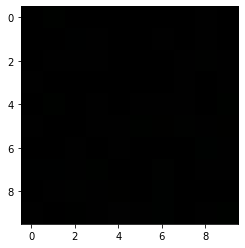

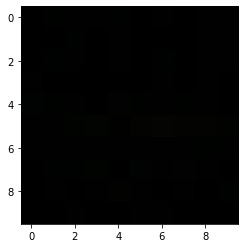

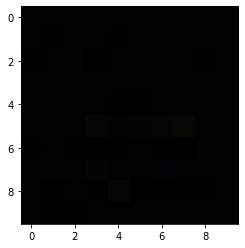

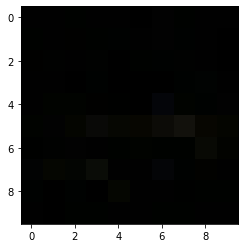

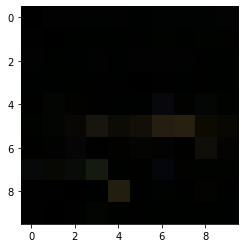

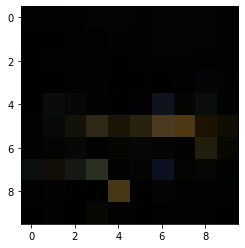

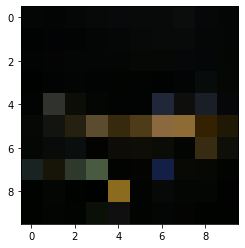

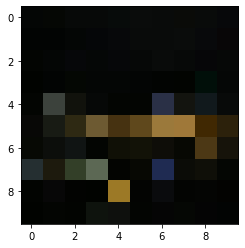

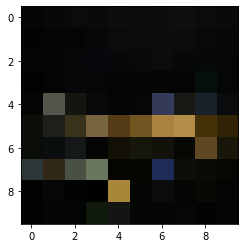

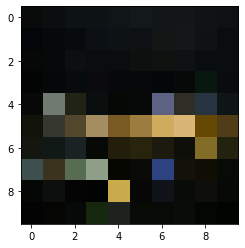

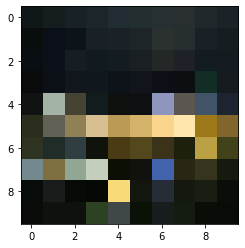

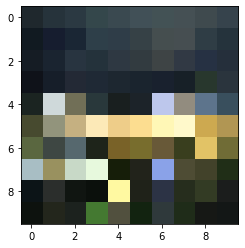

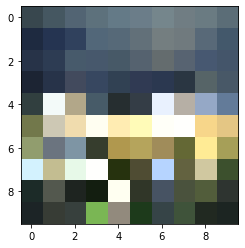

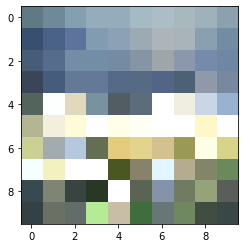

(3, 100, 14)


In [103]:
# Downsampling
size = (10, 10)
interpolation = cv2.INTER_LINEAR

channels = img_set.shape[3]
sampled_pixels = []
for img in img_set:
    ds_img = cv2.resize(img, size, interpolation=interpolation)
    imshow(ds_img)
    ds_vec = np.moveaxis(np.reshape(ds_img, (-1, channels, 1)), 1, 0)
    if len(sampled_pixels) > 0:
        sampled_pixels = np.concatenate((sampled_pixels, ds_vec), axis=2)
    else:
        sampled_pixels = ds_vec

sampled_pixels = np.array(sampled_pixels)
print(sampled_pixels.shape)

## Solve Response Curve 

(3, 256)


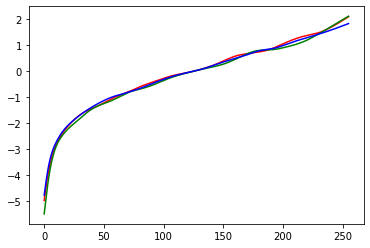

In [7]:
# Optimization
# response curve

def gsolve(Z, B, l, w):
    '''
    Assumes:
        Zmin = 0
        Zmax = 255

    Arguments:
        Z(c, i, j): sample pixel values at position i in image j of channel c
        B(j): log delta t(exposure time) of image j
        l: lambda, weighting regression term
        w(z): weighting function

    Returns:
        g(c, z): log exposure corresponding to pixel value z of chammel c
        lE(c, i): log irradiance at pixel position i of channel c
    '''

    g = []
    # lE = []

    # parameters
    n = 256 # intensity range
    channels, num_pixels, num_imgs = np.shape(Z)

    for c in range(channels):

        A = np.zeros((num_pixels * num_imgs + n + 1, n + num_pixels))
        b = np.zeros((A.shape[0], 1))

        k = 1 # current row of A
        for i in range(num_pixels):
            for j in range(num_imgs):
                # weight of current intensity
                wij = w[Z[c, i, j]]

                A[k, Z[c, i, j]] = wij
                A[k, n + i] = -wij
                b[k] = wij * B[j]

                k += 1

        # restrict 127 to be 0
        A[k, 127] = 1
        k += 1

        # smoothness term
        for i in range(n-2):
            lw = l * w[i+1]

            A[k, i] = lw
            A[k, i+1] = -2 * lw
            A[k, i+2] = lw

            k += 1
        
        # least-square solution for linear matrix equation
        x = np.linalg.lstsq(A, b, rcond=None)[0]
        g.append(x[:n])
        # lE.append(x[n+1:])

    return np.reshape(g, (channels, n))

# log exprosure time
ln_exp_time = np.log(exposure_time)
# hat weighting function
Zmin = 0
Zmax = 255
Zmed = (Zmin + Zmax)/2
hat_weight = np.array([z-Zmin if z <= Zmed else Zmax-z for z in range(256)])/int(Zmed)

g = gsolve(sampled_pixels, ln_exp_time, 30, hat_weight)
print(g.shape)

# plot
plt.plot(g[0], color='r')
plt.plot(g[1], color='g')
plt.plot(g[2], color='b')
plt.show()

## Construct Radiance Map

In [8]:
# Construct Radiance Map
def HDR(Z, B, g, w):

    num_imgs, height, width, channels = np.shape(Z)
    lE = np.zeros((channels, height, width))

    '''
    # move axis version
    mZ = np.moveaxis(Z, [0, 3], [3, 0])
    for c in range(channels):
        wij = w[mZ[c]]
        lE[c] = np.sum(wij*(g[c, mZ[c]]-B), axis=-1) / np.sum(wij, axis=-1)
    
    '''
    # loop version
    progress = '0%'
    
    for c in range(channels):
        for x in range(height):
            for y in range(width):
                wij = w[Z[:, x, y, c]]
                swij = np.sum(wij)
                # check for overflow
                if swij == 0:
                    if np.all(Z[:, x, y, c] == 255):
                        lE[c, x, y] = np.inf
                    elif np.all(Z[:, x, y, c] == 0):
                        lE[c, x, y] = -np.inf
                    print(x, y, Z[:, x, y, c])
                else:
                    lE[c, x, y] = np.sum(wij * (g[c, Z[:, x, y, c]] - B)) / swij
            
            # display progress
            new_prog = '{}%'.format(int((c*height + x)/(channels*height) * 100))
            if new_prog != progress:
                progress = new_prog
                print(progress)
    
    # clip fix overflow
    for c in range(channels):
        lE[c, lE[c] == np.inf] = np.max(lE[c, lE[c] != np.inf])
        lE[c, lE[c] == -np.inf] = np.min(lE[c, lE[c] != -np.inf])
        
    # change from color major to row major
    lE = np.moveaxis(lE, 0, -1)
    lE = np.exp(lE)

    return lE

HDR_img = HDR(img_set, ln_exp_time, g, hat_weight)
print(HDR_img.shape)

1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
1592 3456 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1604 4987 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1604 4988 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1633 2016 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
18%
1686 1071 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1745 256 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1745 257 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
19%
1769 4448 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1769 4449 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1770 4448 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1776 5037 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1776 5038 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1780 5034 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1780 5035 [255 255 255 255 255 255 255 255 255 255 

1353 3537 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1362 4693 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
82%
83%
1547 3133 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1547 3135 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1561 3297 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1561 3301 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
84%
1641 1894 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1641 1895 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1641 1896 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1674 1853 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
85%
1754 1667 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
86%
87%
88%
89%
90%
2206 5381 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
91%
92%
93%
94%
95%
96%
2736 2678 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97%
98%
2942 2385 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
99%
(3, 

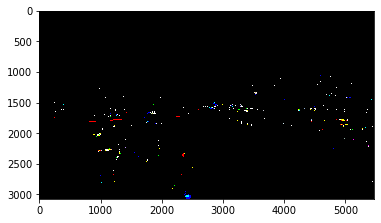

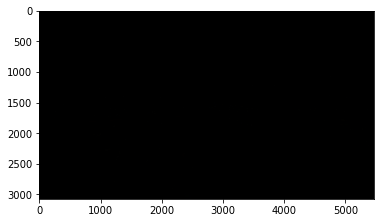

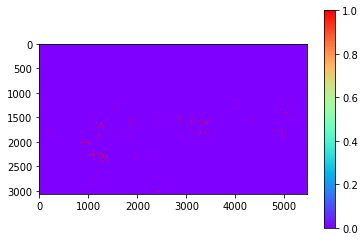

In [21]:
# normalize
HDR_img -= np.min(HDR_img)
HDR_img = 255 * HDR_img / np.max(HDR_img)

# save raw data
imshow(HDR_img)
# linear mapping
# quantize
HDR_img = HDR_img.astype(np.uint8)
imshow(HDR_img)
# heatmap of gray scale
HDR_gray = cv2.cvtColor(HDR_img, cv2.COLOR_RGB2GRAY)
plt.imshow(HDR_gray, 'rainbow')
plt.colorbar()
plt.show()

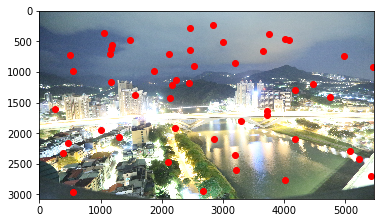

In [11]:
# sampled pixels
plt.plot(coords[:, 1], coords[:, 0], 'ro')
imshow(img_set[-1])

In [33]:
test = np.load(op.join(data_path, 'radiance_map.npy'))


In [11]:
print(radiance_map.shape)
radiance_map = np.moveaxis(radiance_map, 0, -1)

print(radiance_map.shape)

(3, 3072, 5472)
(3072, 5472, 3)


In [35]:

print(test[0, 0])
test = np.exp(test)

print(test[0, 0])

[-2.28316631 -2.1172366  -1.76648912]
[0.10196086 0.12036378 0.17093206]


In [36]:
print(test[0, 0])
test -= np.min(test)
test = 255 * test / np.max(test)
print(test[0, 0])

[0.10196086 0.12036378 0.17093206]
[3.22165684 3.84374295 5.55313529]


In [13]:
cv2.imwrite(op.join(data_path, 'radiance_map.hdr'), radiance_map)

True

In [38]:
test2 = cv2.imread(op.join(data_path, 'test.hdr'), cv2.IMREAD_ANYDEPTH)
print(test2[0, 0])

[0.01171875 0.015625   0.0234375 ]


In [14]:
HDR_img = radiance_map

In [15]:
HDR_img = np.exp(HDR_img)

In [20]:
np.max(HDR_img)

255